In [ ]:
!ls

sample_data


#External Databases

In [1]:
! pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-5kuoewr6
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-5kuoewr6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 7.1 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 895 kB 60.3 MB/s 
     |████████████████████████████████| 6.5 MB 57.0 MB/s 
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3958421 sha256=cd8764b9213f50063d35623e35920ee3dcc0a83f47f965ce2c92538af1b5dcaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3im961t/wheels/90/a5/44/6bcd83827c8a60628c5ad602f429cd5076bcce5f2a90054947
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [2]:
! pip install ray[tune]

     |████████████████████████████████| 52.7 MB 129 kB/s 
     |████████████████████████████████| 4.1 MB 45.4 MB/s 
     |████████████████████████████████| 226 kB 58.3 MB/s 
     |████████████████████████████████| 125 kB 60.4 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [3]:
!pip install datasets

     |████████████████████████████████| 325 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.4 MB/s 
     |████████████████████████████████| 136 kB 54.6 MB/s 
     |████████████████████████████████| 212 kB 50.2 MB/s 
     |████████████████████████████████| 127 kB 56.7 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 271 kB 54.2 MB/s 
     |████████████████████████████████| 144 kB 54.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install seqeval

     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=e939dab718498f4a59987b9c175e3cabf6c2dcf3ab5561a9270bb66f977ff74a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


#Libraries

In [5]:
from google.colab import files

import os
import re
import json
import string

import torch
import torch.nn as nn

import numpy as np
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from datasets import load_dataset
#from collections import Counter
#from conlleval import evaluate

import tensorflow_hub as hub
from keras import backend as K
import torch.nn.functional as F

import transformers
print(transformers.__version__)
from transformers import TrainingArguments
from transformers import Trainer

from transformers import Trainer
from transformers.trainer_utils import EvalLoopOutput

from seqeval.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs
from datasets import load_metric
from sklearn.metrics import f1_score, precision_score, recall_score

from transformers import AutoTokenizer, AutoModel
BertTokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
BertEmbModel = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

4.18.0.dev0


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#Loading Dataset

In [6]:
uploaded = files.upload()

Saving dev.json to dev.json
Saving test.json to test.json
Saving train.json to train.json


In [7]:
class SciERCDataset(torch.utils.data.Dataset):
  def __init__(self, raw_data, entity_map, max_length=250):
    # Need to fix sentence offset for labels!!
    for i, sample in enumerate(raw_data):
      sent_offset = 0
      for j, sent in enumerate(sample['sentences']):
        for k, ner in enumerate(sample['ner'][j]):
          raw_data[i]['ner'][j][k] = [raw_data[i]['ner'][j][k][0] - sent_offset, 
                                      raw_data[i]['ner'][j][k][1] - sent_offset, 
                                      raw_data[i]['ner'][j][k][2]]
        sent_offset += len(sent)

    sentences = [x['sentences'] for x in raw_data]
    self.raw_x = [sent for sublist in sentences for sent in sublist]

    ners = [x['ner'] for x in raw_data]
    self.raw_y = [ner for sublist in ners for ner in sublist]
    
    self.entity_map = entity_map
    self.max_length = max_length

  def tokenize_and_preserve_labels(self, sentence, text_labels):
    """
    The tokenizer can split single words into multiple tokens - this breaks
    the labels, so we need to keep track of this!
    """
    tokenized_sentence = []
    labels = []
    prev_label = 0

    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = BertTokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        if label != 0:  
          labels.extend([-100] * n_subwords)
          labels[-1 * n_subwords] = label
        else:
          labels.extend([label] * n_subwords)
        
        prev_label = label

    return tokenized_sentence, labels

  def __getitem__(self, idx):
    tokens = self.raw_x[idx]
    labels = np.zeros((len(tokens)))

    #For Span
    for ner in self.raw_y[idx]:  # Returns [start_idx, end_idx, string label]
      assert len(tokens) >= ner[0], '{}, {}'.format(tokens, ner)
      ner_name = 'I-' + ner[-1]
      label = self.entity_map(ner_name)  # Get the integer label
      labels[ner[0]:ner[1]+1] = label
      #labels[ner[0]] = label - 1 

    #For BIO
    #for ner in self.raw_y[idx]:  # Returns [start_idx, end_idx, string label]
    #  assert len(tokens) >= ner[0], '{}, {}'.format(tokens, ner)  # Double checking the labels are correct
    #  ner_name = 'I-' + ner[-1]  # assume all are "I" labels
    #  label = self.entity_map(ner_name)  # Get the integer label
    #  labels[ner[0]:ner[1]+1] = label  
    #  labels[ner[0]] = label - 1  # Change first one to "B" label

    # This could be moved to __init__ to save time?
    tokens, labels = self.tokenize_and_preserve_labels(tokens, labels)

    # Convert each token to an id number 
    input_ids = BertTokenizer.convert_tokens_to_ids(tokens)
    
    # add and adjust for special tokens
    input_ids = [BertTokenizer.cls_token_id] + input_ids + [BertTokenizer.sep_token_id]  
    labels = [0] + labels + [0]

    # Pad inputs
    input_ids = torch.tensor(np.pad(input_ids, [0, self.max_length-len(input_ids)]))
    labels = torch.tensor(np.pad(labels, [0, self.max_length-len(labels)], constant_values=-100))

    attention_mask = torch.tensor([int(i != 0) for i in input_ids])

    return {'input_ids': [input_ids], 'attention_mask': [attention_mask], 'labels': labels}

  def __len__(self):
    return len(self.raw_y)

In [8]:
def Entity2ID(Sc_Entity):
  return {
        'I-Task': 1,
        'I-Method': 2,
        'I-Metric': 3,
        'I-Material': 4,
        'I-OtherScientificTerm': 5,
        'I-Generic': 6,
        'None': 0
    }[Sc_Entity]

def ID2Entity(Sc_Entity):
  return {
        1: 'I-Task',
        2: 'I-Method',
        3: 'I-Metric',
        4: 'I-Material',
        5: 'I-OtherScientificTerm',
        6: 'I-Generic',
        0: 'O'
    }[Sc_Entity]

In [9]:
train_data = []
with open('train.json','r') as f:
  for line in f:
    train_data.append(json.loads(line))

test_data = []
with open('test.json','r') as f:
  for line in f:
    test_data.append(json.loads(line))

val_data = []
with open('dev.json','r') as f:
  for line in f:
    val_data.append(json.loads(line))

#train_data[3]['sentences'][0], train_data[3]['ner'][0], len(train_data[3]['sentences'][1])
len(train_data), len(test_data), len(val_data)

(350, 100, 50)

In [10]:
train = SciERCDataset(train_data, Entity2ID)
val = SciERCDataset(val_data, Entity2ID)
test = SciERCDataset(test_data, Entity2ID)

In [11]:
len(train), len(test), len(val)

(1861, 551, 275)

In [12]:
#tokens = BertTokenizer.convert_ids_to_tokens(train[1]['input_ids'][0])
#labels = train[1]['labels']
#print(' '.join(tokens))
#print(labels)

In [13]:
train[0]

{'attention_mask': [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 'input_ids': [tensor([  102,  6170,   165,   817,   147,   195,   428,   579,  2220,   579,
           2159,   191,   

# Pytorch Model Definition

In [ ]:
class NerModel(nn.Module):
  def __init__(self, b_embeddings, emb_dims=768, ff_dims=14, out_dims=7):
    super(NerModel, self).__init__()
    self.sci_embeddings = b_embeddings
    self.embd_dropout = nn.Dropout(0.1)
    self.ff_dropout = nn.Dropout(0.1)
    self.ff = nn.Linear(emb_dims, ff_dims)
    self.tanh = nn.Tanh()
    self.lstm = nn.LSTM(emb_dims, 100, 1, bidirectional=True)
    self.lstm_drop = nn.Dropout(0.4)
    self.ff = nn.Linear(200, ff_dims)
    self.ff_act = nn.ReLU()
    self.classifier = nn.Linear(ff_dims, out_dims)
  def forward(self, **inputs):
    embds = self.sci_embeddings(**inputs)['last_hidden_state']
    out = self.embd_dropout(embds)
    out, _ = self.lstm(out)
    out = self.tanh(out)
    out = self.lstm_drop(out)
    out = self.ff(out)
    out = self.ff_act(out)
    out = self.ff_dropout(out)
    out = self.classifier(out)
    return out


# Metrics and Configs

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

import math

def load_param():
  for n, v in best_run.hyperparameters.items():
    if n == 'seed':
      setattr(trainer.args, n, math.ceil(v))
      print(n, math.ceil(v))
    else:
      setattr(trainer.args, n, v)
      print(n, v)   

In [ ]:
batch_size = 4
training_args = TrainingArguments(
    "trained_scibert_ner_model", # output dir
    learning_rate=1e-5, 
    num_train_epochs=10, 
    dataloader_drop_last=True,
    per_device_eval_batch_size=batch_size, 
    per_device_train_batch_size=batch_size,
    logging_steps=50,
    save_steps=len(train) // batch_size,
    lr_scheduler_type='cosine',
    evaluation_strategy='steps',
    eval_steps=len(train) // batch_size)
#print(training_args)

In [ ]:
def collator(batch):
  out =  {
      'input_ids': torch.stack([(x['input_ids'][0]) for x in batch]),
      'attention_mask': torch.stack([x['attention_mask'][0] for x in batch]),
      'labels': torch.stack([x['labels'].clone().detach() for x in batch])
  }
  return out

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight, gamma, reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, ignore_index=-100, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_labels=7):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs
        
        #weights = torch.tensor([0.1, 1.5, 1.55, 1.9, 1.75, 1.65, 1.9]).cuda()  # The no-class label has too many examples, we need to weight the loss - this probably needs further tuning 
        
        #weights = torch.tensor([0.1, 1.5, 1.2, 1.9, 1.75, 1.3, 1.85]).cuda()

        #weights = torch.tensor([0.89, 1.73, 1.69, 1.79, 1.76, 1.7, 1.77]).cuda()

        #weights = torch.tensor([0.89, 1.69, 1.65, 1.84, 1.75, 1.66, 1.77]).cuda()

        #weights = torch.tensor([0.95, 1.6, 1.5, 1.94, 1.7, 1.55, 1.83]).cuda()

        #weights = torch.tensor([0.12, 0.83, 0.78, 1.0, 0.88, 0.8, 0.95]).cuda()

        #weights = torch.tensor([0.42, 1.5, 1.2, 2.0, 1.6, 1.4, 1.8]).cuda()

        #weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda()

        #weights = torch.tensor([0.1, 1.36, 0.93, 7.45, 2.66, 1.01, 3.51]).cuda()

        weights = torch.tensor([0.26, 0.95, 0.92, 0.99, 0.97, 0.93, 0.98]).cuda()

        gamma=5
        loss_fct = FocalLoss(weight=weights, gamma=gamma)
        loss = loss_fct(logits.view(-1, num_labels), labels.long().view(-1))
        return (loss, outputs) if return_outputs else loss

    def evaluation_loop(self, dataloader, description, prediction_loss_only=None, ignore_keys=None, metric_key_prefix="eval", num_labels=7):
      args = self.args
      prediction_loss_only = prediction_loss_only if prediction_loss_only is not None else args.prediction_loss_only

      self.model.eval()

      all_losses = []
      all_preds = []
      all_labels = []
      for step, sample in enumerate(dataloader):
        for i in range(0, len(sample['labels'])):
          inputs = {}
          inputs['input_ids'] = torch.stack([sample['input_ids'][i].cuda()])
          inputs['attention_mask'] = torch.stack([sample['attention_mask'][i].cuda()])
          inputs['labels'] = torch.stack([sample['labels'][i].cuda()])
          labels = inputs['labels'][0].cpu().numpy()
          
          (loss, logits) = self.compute_loss(self.model, inputs, return_outputs=True)
          logits = logits[0].cpu().detach().numpy()
          preds = np.argmax(nn.Softmax(dim=-1)(torch.tensor(logits)).numpy(), axis=-1)

          all_losses = np.concatenate((all_losses, [loss.detach().cpu().numpy()]), axis=0)

          preds = preds[labels != -100]
          labels = labels[labels != -100]
          all_preds = np.concatenate((all_preds, preds))
          all_labels = np.concatenate((all_labels, labels))

      metrics = {}
      metrics['macro_f1'] = f1_score(all_labels, all_preds, average='macro')
      metrics['macro_precision'] = precision_score(all_labels, all_preds, average='macro', zero_division=0)
      metrics['macro_recall'] = recall_score(all_labels, all_preds, average='macro', zero_division=0)
      metrics['micro_f1'] = f1_score(all_labels, all_preds, average='micro')
      metrics['micro_precision'] = precision_score(all_labels, all_preds, average='micro', zero_division=0)
      metrics['micro_recall'] = recall_score(all_labels, all_preds, average='micro', zero_division=0)

      metrics['macro_f1_no_o'] = f1_score(all_labels, all_preds, average='macro', labels=[1, 2, 3, 4, 5, 6])
      metrics['macro_precision_no_o'] = precision_score(all_labels, all_preds, average='macro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)
      metrics['macro_recall_no_o'] = recall_score(all_labels, all_preds, average='macro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)
      metrics['micro_f1_no_o'] = f1_score(all_labels, all_preds, average='micro', labels=[1, 2, 3, 4, 5, 6])
      metrics['micro_precision_no_o'] = precision_score(all_labels, all_preds, average='micro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)
      metrics['micro_recall_no_o'] = recall_score(all_labels, all_preds, average='micro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)

      for key in list(metrics.keys()):
        if not key.startswith(metric_key_prefix):
          metrics[metric_key_prefix + '_' + key] = metrics.pop(key)
      
      metrics[metric_key_prefix + '_loss'] = all_losses.mean().item()

      return EvalLoopOutput(predictions=all_preds, label_ids=all_labels, metrics=metrics, num_samples=len(dataloader))

In [ ]:
def my_hp_space_ray(trial):
    from ray import tune

    return {
        "learning_rate": tune.loguniform(9e-6, 1e-4),
        "num_train_epochs": tune.choice(range(5, 25)),
        "weight_decay": tune.uniform(0.0, 0.2),
        "per_device_train_batch_size": tune.choice([4, 8, 16]),  #<16 definetly not working
    }

# Hyperparameter Tuning

In [ ]:
def model_init():
    x = NerModel(BertEmbModel)
    x.sci_embeddings.requires_grad = False
    return x

trainer = MultilabelTrainer(model_init=model_init,
                            args=training_args,
                            train_dataset=train,
                            eval_dataset=val,
                            data_collator=collator  # defines how to merge data into batches, using the collator function above
                            )

In [ ]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

best_run = trainer.hyperparameter_search(backend="ray", 
                                         resources_per_trial={"gpu": 1, "cpu": 0},
                                         n_trials=18, 
                                         direction="maximize", 
                                         hp_space=my_hp_space_ray,
                                         search_alg=HyperOptSearch(metric='eval_micro_recall_no_o', mode="max"),  #'eval_*f1_micro'
                                         scheduler=ASHAScheduler(metric='eval_micro_recall_no_o', mode="max")
                                         )

In [ ]:
best_run

BestRun(run_id='0b9563ea', objective=9.572004533254779, hyperparameters={'learning_rate': 2.5923213776958604e-05, 'num_train_epochs': 20, 'weight_decay': 0.028135787671833536, 'per_device_train_batch_size': 16})

# Cossvalidation

In [ ]:
#import tensorflow as tf
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
from torch import nn
from transformers import Trainer

#print('GPU detected:', tf.config.list_physical_devices('GPU'))
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
results = np.zeros(5)
resultss = np.zeros(5)
dataset = ConcatDataset([train, test])



In [ ]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    #train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    #test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    local_train = []
    #i = 0
    for idx in train_ids:
      #if i <= 1920:
        local_train.append(dataset[idx])
      #i += 1
    
    local_test = []
    #i = 0
    for idx in test_ids:
      #if i <= 480:
        local_test.append(dataset[idx])
      #i += 1

    training_args = TrainingArguments("trained_scibert_ner_model", # output dir
                                      learning_rate=2.5923213776958604e-05, 
                                      num_train_epochs=20, 
                                      per_device_eval_batch_size=16, 
                                      per_device_train_batch_size=16,
                                      logging_steps=50,
                                      save_steps=len(train) // batch_size,
                                      lr_scheduler_type='cosine',
                                      evaluation_strategy='steps',
                                      weight_decay=0.028135787671833536,
                                      dataloader_drop_last=True,
                                      eval_steps=len(train) // batch_size
                                      )

    #learning_rate 2.5923213776958604e-05
    #num_train_epochs 20
    #weight_decay 0.028135787671833536
    #per_device_train_batch_size 16

    # Init the neural network
    ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training
    
    trainer = MultilabelTrainer(model=ner_model,
                                args=training_args,
                                train_dataset=local_train,
                                eval_dataset=local_test,
                                data_collator=collator  # defines how to merge data into batches, using the collator function above
                                )

    ##Loading Best parameters
    #load_param()

    #Training
    trainer.train()
          
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(ner_model.state_dict(), save_path)

    # Evaluationfor this fold
    #correct, total = 0, 0
    with torch.no_grad():
      result = trainer.evaluate(local_test)
      print(result)

      # Print accuracy
      print('Accuracy for fold ', fold, ': ', result['eval_micro_f1_no_o'])
      print('--------------------------------')
      results[fold] = result['eval_micro_f1_no_o']
      resultss[fold] = result['eval_micro_f1']
      del result
    


FOLD 0
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1929
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2400


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.088200,0.166238,0.704257,0.699223,0.725757,0.881141,0.881141,0.881141,0.662846,0.653983,0.690811,0.694170,0.662194,0.729392
930,0.021700,0.127322,0.734887,0.702372,0.780138,0.892900,0.892900,0.892900,0.697567,0.657153,0.752765,0.718767,0.690876,0.749005
1395,0.010800,0.114582,0.752670,0.733069,0.777347,0.897169,0.897169,0.897169,0.718250,0.693425,0.748949,0.731399,0.708500,0.755827
1860,0.007100,0.112511,0.747570,0.721543,0.782701,0.896794,0.896794,0.896794,0.712255,0.679563,0.755501,0.730654,0.703899,0.759522
2325,0.006400,0.112283,0.737827,0.706369,0.780746,0.893649,0.893649,0.893649,0.701077,0.661837,0.753610,0.722987,0.694321,0.754122


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2325
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.7380146694507802, 'eval_macro_precision': 0.7066210372689362, 'eval_macro_recall': 0.7807462081901918, 'eval_micro_f1': 0.8936488915518275, 'eval_micro_precision': 0.8936488915518275, 'eval_micro_recall': 0.8936488915518275, 'eval_macro_f1_no_o': 0.7012959679611025, 'eval_macro_precision_no_o': 0.6621312164423391, 'eval_macro_recall_no_o': 0.7536100515117014, 'eval_micro_f1_no_o': 0.722986782940455, 'eval_micro_precision_no_o': 0.6943208584140277, 'eval_micro_recall_no_o': 0.7541216600341103, 'eval_loss': 0.11228734726673792, 'eval_runtime': 5.9796, 'eval_samples_per_second': 5.017, 'eval_steps_per_second': 0.334, 'epoch': 20.0}
Accuracy for fold  0 :  0.722986782940455
--------------------------------
FOLD 1
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1929
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2400


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.073900,0.090634,0.910602,0.892874,0.930701,0.966267,0.966267,0.966267,0.898034,0.876029,0.922785,0.908550,0.887823,0.930268
930,0.020500,0.040740,0.913258,0.898679,0.930143,0.966495,0.966495,0.966495,0.901247,0.882666,0.922487,0.911756,0.887320,0.937576
1395,0.010900,0.030373,0.916400,0.906370,0.927257,0.969754,0.969754,0.969754,0.904578,0.892239,0.917875,0.917520,0.907143,0.928136
1860,0.007400,0.025919,0.918512,0.905818,0.933050,0.969982,0.969982,0.969982,0.907073,0.891094,0.925188,0.919636,0.900964,0.939099
2325,0.007200,0.025689,0.918038,0.907355,0.930274,0.970058,0.970058,0.970058,0.906518,0.893122,0.921715,0.919599,0.904566,0.935140


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2325
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9180383819076718, 'eval_macro_precision': 0.9073546389905337, 'eval_macro_recall': 0.9302743149842237, 'eval_micro_f1': 0.9700576106731352, 'eval_micro_precision': 0.9700576106731352, 'eval_micro_recall': 0.9700576106731352, 'eval_macro_f1_no_o': 0.9065180090369171, 'eval_macro_precision_no_o': 0.8931215982329932, 'eval_macro_recall_no_o': 0.9217148666068803, 'eval_micro_f1_no_o': 0.9195987423266957, 'eval_micro_precision_no_o': 0.9045655375552283, 'eval_micro_recall_no_o': 0.9351400730816078, 'eval_loss': 0.025688963839396214, 'eval_runtime': 5.9616, 'eval_samples_per_second': 5.032, 'eval_steps_per_second': 0.335, 'epoch': 20.0}
Accuracy for fold  1 :  0.9195987423266957
--------------------------------
FOLD 2
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1930
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2400


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.049500,0.052560,0.957545,0.936554,0.982265,0.984525,0.984525,0.984525,0.951894,0.926235,0.981888,0.964196,0.944687,0.984527
930,0.016500,0.020772,0.961748,0.944221,0.981397,0.986110,0.986110,0.986110,0.956602,0.935230,0.980440,0.966876,0.951262,0.983010
1395,0.008700,0.013160,0.963723,0.947456,0.982135,0.987167,0.987167,0.987167,0.958847,0.939037,0.981150,0.969960,0.955817,0.984527
1860,0.006300,0.011043,0.964176,0.947610,0.982823,0.987469,0.987469,0.987469,0.959334,0.939167,0.981920,0.970412,0.956125,0.985133
2325,0.007900,0.010605,0.964409,0.947994,0.982837,0.987544,0.987544,0.987544,0.959596,0.939614,0.981920,0.970557,0.956406,0.985133


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2325
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.96440856511848, 'eval_macro_precision': 0.9479941507221205, 'eval_macro_recall': 0.9828374433008614, 'eval_micro_f1': 0.9875443496640749, 'eval_micro_precision': 0.9875443496640749, 'eval_micro_recall': 0.9875443496640749, 'eval_macro_f1_no_o': 0.9595960183245706, 'eval_macro_precision_no_o': 0.9396140988361131, 'eval_macro_recall_no_o': 0.981919870498913, 'eval_micro_f1_no_o': 0.9705574652518308, 'eval_micro_precision_no_o': 0.9564064801178204, 'eval_micro_recall_no_o': 0.9851334951456311, 'eval_loss': 0.01060348430534456, 'eval_runtime': 5.9842, 'eval_samples_per_second': 5.013, 'eval_steps_per_second': 0.334, 'epoch': 20.0}
Accuracy for fold  2 :  0.9705574652518308
--------------------------------
FOLD 3
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1930
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2400


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.044400,0.054563,0.962022,0.959396,0.965089,0.986476,0.986476,0.986476,0.956623,0.953157,0.960602,0.964169,0.957647,0.970781
930,0.016200,0.023185,0.966149,0.964788,0.967826,0.987642,0.987642,0.987642,0.961386,0.959359,0.963778,0.967742,0.960635,0.974955
1395,0.008700,0.016024,0.965666,0.964543,0.967133,0.987409,0.987409,0.987409,0.960822,0.959057,0.962986,0.966864,0.959483,0.974359
1860,0.006700,0.013759,0.965281,0.963702,0.967212,0.987642,0.987642,0.987642,0.960355,0.958075,0.963044,0.967446,0.960341,0.974657
2325,0.006100,0.013329,0.965363,0.963845,0.967227,0.987720,0.987720,0.987720,0.960442,0.958242,0.963044,0.967589,0.960623,0.974657


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2325
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9653625368667559, 'eval_macro_precision': 0.963844921441649, 'eval_macro_recall': 0.9672274607332901, 'eval_micro_f1': 0.9877195709622261, 'eval_micro_precision': 0.9877195709622261, 'eval_micro_recall': 0.9877195709622261, 'eval_macro_f1_no_o': 0.9604416245878511, 'eval_macro_precision_no_o': 0.9582417739479423, 'eval_macro_recall_no_o': 0.9630444569222277, 'eval_micro_f1_no_o': 0.9675891667899955, 'eval_micro_precision_no_o': 0.9606229797237732, 'eval_micro_recall_no_o': 0.9746571258199165, 'eval_loss': 0.013327692839569256, 'eval_runtime': 5.9777, 'eval_samples_per_second': 5.019, 'eval_steps_per_second': 0.335, 'epoch': 20.0}
Accuracy for fold  3 :  0.9675891667899955
--------------------------------
FOLD 4
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1930
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2400


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.041200,0.048911,0.972312,0.961618,0.983504,0.990557,0.990557,0.990557,0.968444,0.955452,0.982015,0.975796,0.966860,0.984898
930,0.015700,0.019438,0.972349,0.960683,0.984586,0.990557,0.990557,0.990557,0.968513,0.954345,0.983344,0.976253,0.966618,0.986082
1395,0.008500,0.013874,0.969098,0.956217,0.982832,0.990114,0.990114,0.990114,0.964711,0.949167,0.981248,0.974329,0.965407,0.983417
1860,0.006400,0.010461,0.973510,0.963802,0.983583,0.990778,0.990778,0.990778,0.969825,0.958016,0.982058,0.976369,0.967986,0.984898
2325,0.006200,0.010288,0.973450,0.963683,0.983583,0.990778,0.990778,0.990778,0.969756,0.957878,0.982058,0.976369,0.967986,0.984898


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2325
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9734503131960354, 'eval_macro_precision': 0.9636834153478006, 'eval_macro_recall': 0.9835828129294909, 'eval_micro_f1': 0.9907783105864995, 'eval_micro_precision': 0.9907783105864995, 'eval_micro_recall': 0.9907783105864995, 'eval_macro_f1_no_o': 0.9697561794729888, 'eval_macro_precision_no_o': 0.9578777112252652, 'eval_macro_recall_no_o': 0.9820583790196914, 'eval_micro_f1_no_o': 0.9763687068838984, 'eval_micro_precision_no_o': 0.9679860302677532, 'eval_micro_recall_no_o': 0.9848978383180338, 'eval_loss': 0.010286054790291625, 'eval_runtime': 5.9773, 'eval_samples_per_second': 5.019, 'eval_steps_per_second': 0.335, 'epoch': 20.0}
Accuracy for fold  4 :  0.9763687068838984
--------------------------------


# Results

In [ ]:
results

array([0.72298678, 0.91959874, 0.97055747, 0.96758917, 0.97636871])

In [ ]:
resultss

array([0.89364889, 0.97005761, 0.98754435, 0.98771957, 0.99077831])

In [ ]:
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
key = 0
for value in results:
  print(f'Fold {key}: {value} %')
  sum += value
  key += 1
print(f'Average: {sum/len(results)} %')

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 0.722986782940455 %
Fold 1: 0.9195987423266957 %
Fold 2: 0.9705574652518308 %
Fold 3: 0.9675891667899955 %
Fold 4: 0.9763687068838984 %
Average: 0.9114201728385751 %


# Pytorch Training - Loop UPDT

In [ ]:
device = 'cuda'

In [ ]:
training_args = TrainingArguments("trained_scibert_ner_model", # output dir
                                      learning_rate=2.5923213776958604e-05, 
                                      weight_decay=0.028135787671833536,
                                      num_train_epochs=20, 
                                      per_device_eval_batch_size=16,
                                      per_device_train_batch_size=16,
                                      logging_steps=50,
                                      dataloader_drop_last=True,
                                      save_steps=len(train) // batch_size,
                                      eval_steps=len(train) // batch_size,
                                      lr_scheduler_type='cosine',
                                      evaluation_strategy='steps',
                                      report_to='all'#,
                                      #warmup_ratio=0.2
                                      )

#learning_rate 2.5923213776958604e-05
#num_train_epochs 20
#weight_decay 0.028135787671833536
#per_device_train_batch_size 16

#load_param()

In [ ]:
loop_val = 10
loop_results = np.zeros(loop_val)
loop_resultss = np.zeros(loop_val)
for r in range(loop_val):

  ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training

  trainer = MultilabelTrainer(
      model=ner_model, 
      args=training_args, 
      train_dataset=train, 
      eval_dataset=test,
      data_collator=collator  # defines how to merge data into batches, using the collator function above
  )

  # Print
  print(f'Train run #{r}')
  print('--------------------------------')

  trainer.train()

  # Process is complete.
  print('Training process has finished.')

  # Print about testing
  print('Starting testing')

  with torch.no_grad():
    result = trainer.evaluate(test)
    print(result)

    # Print accuracy
    print('Accuracy for fold ', r, ': ', result['eval_micro_f1_no_o'], ' -- ', result['eval_micro_f1'])
    print('--------------------------------')
    loop_results[r] = result['eval_micro_f1_no_o']
    loop_resultss[r] = result['eval_micro_f1']
    del result

  if r > 0:
    if loop_results[r] < loop_results[r-1]:
      save_path = f'./model-fold-{r}.pth'
      torch.save(ner_model.state_dict(), save_path)

  print('Testing process has finished.')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


Train run #0
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.043100,0.112553,0.634953,0.608368,0.672703,0.886966,0.886966,0.886966,0.580817,0.547576,0.627023,0.689484,0.664754,0.716126
930,0.012300,0.078683,0.642579,0.605309,0.696520,0.886632,0.886632,0.886632,0.590127,0.542561,0.656944,0.702553,0.659656,0.751417
1395,0.006800,0.079707,0.642687,0.611882,0.689004,0.891309,0.891309,0.891309,0.589665,0.551092,0.646251,0.704447,0.675089,0.736476
1860,0.005000,0.078377,0.649642,0.622049,0.687444,0.893780,0.893780,0.893780,0.597510,0.562928,0.643935,0.708225,0.681180,0.737506


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


{'eval_macro_f1': 0.6491221439722131, 'eval_macro_precision': 0.6212911739714586, 'eval_macro_recall': 0.6872948343378331, 'eval_micro_f1': 0.8938472843877346, 'eval_micro_precision': 0.8938472843877346, 'eval_micro_recall': 0.8938472843877346, 'eval_macro_f1_no_o': 0.5969067902812537, 'eval_macro_precision_no_o': 0.5621762512371274, 'eval_macro_recall_no_o': 0.6436406722306137, 'eval_micro_f1_no_o': 0.7079821517104611, 'eval_micro_precision_no_o': 0.6822742474916388, 'eval_micro_recall_no_o': 0.7357032457496137, 'eval_loss': 0.07871574303129926, 'eval_runtime': 17.8756, 'eval_samples_per_second': 1.902, 'eval_steps_per_second': 0.168, 'epoch': 20.0}
Accuracy for fold  0 :  0.7079821517104611  --  0.8938472843877346
--------------------------------
Testing process has finished.
Train run #1
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.027600,0.133964,0.740995,0.706528,0.789184,0.892511,0.892511,0.892511,0.704371,0.661573,0.763097,0.708914,0.679830,0.740598
930,0.009400,0.110268,0.743547,0.708976,0.796506,0.897254,0.897254,0.897254,0.706976,0.664426,0.770919,0.718928,0.693301,0.746522
1395,0.005400,0.093216,0.757352,0.727480,0.794081,0.902331,0.902331,0.902331,0.723072,0.685852,0.768224,0.738184,0.710238,0.768418
1860,0.004000,0.097977,0.759603,0.734710,0.790611,0.903467,0.903467,0.903467,0.725552,0.694823,0.763379,0.737487,0.717032,0.759145


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


{'eval_macro_f1': 0.7615951095470415, 'eval_macro_precision': 0.7402064854193501, 'eval_macro_recall': 0.7881304095387488, 'eval_micro_f1': 0.9040016033135148, 'eval_micro_precision': 0.9040016033135146, 'eval_micro_recall': 0.9040016033135146, 'eval_macro_f1_no_o': 0.7278583496171559, 'eval_macro_precision_no_o': 0.7012785978860241, 'eval_macro_recall_no_o': 0.7604102846260297, 'eval_micro_f1_no_o': 0.7389779559118237, 'eval_micro_precision_no_o': 0.7191613846903949, 'eval_micro_recall_no_o': 0.7599175682637815, 'eval_loss': 0.09610259697996405, 'eval_runtime': 18.784, 'eval_samples_per_second': 1.81, 'eval_steps_per_second': 0.16, 'epoch': 20.0}
Accuracy for fold  1 :  0.7389779559118237  --  0.9040016033135148
--------------------------------
Testing process has finished.
Train run #2
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.017700,0.117935,0.759655,0.744527,0.783828,0.898657,0.898657,0.898657,0.725903,0.705717,0.756563,0.727542,0.698247,0.759402
930,0.006700,0.100786,0.758039,0.724172,0.799677,0.897388,0.897388,0.897388,0.724215,0.681409,0.775956,0.728847,0.691898,0.769964
1395,0.004100,0.100723,0.761205,0.740413,0.786878,0.902064,0.902064,0.902064,0.727550,0.701176,0.759565,0.735992,0.710823,0.763009
1860,0.003100,0.101803,0.761354,0.736382,0.792045,0.902198,0.902198,0.902198,0.727621,0.696703,0.765172,0.733542,0.712103,0.756311


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.7616267030870538, 'eval_macro_precision': 0.7328995051947513, 'eval_macro_recall': 0.7972543407149761, 'eval_micro_f1': 0.9021310708798183, 'eval_micro_precision': 0.9021310708798183, 'eval_micro_recall': 0.9021310708798183, 'eval_macro_f1_no_o': 0.7278811947087155, 'eval_macro_precision_no_o': 0.6922845481089069, 'eval_macro_recall_no_o': 0.771475784380334, 'eval_micro_f1_no_o': 0.7334659373446047, 'eval_micro_precision_no_o': 0.7087938491110043, 'eval_micro_recall_no_o': 0.7599175682637815, 'eval_loss': 0.10070674285110298, 'eval_runtime': 20.887, 'eval_samples_per_second': 1.628, 'eval_steps_per_second': 0.144, 'epoch': 20.0}
Accuracy for fold  2 :  0.7334659373446047  --  0.9021310708798183
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


Testing process has finished.
Train run #3
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.017100,0.119026,0.761921,0.728469,0.806222,0.901864,0.901864,0.901864,0.728087,0.686755,0.782014,0.731079,0.704128,0.760175
930,0.006300,0.103800,0.775002,0.758778,0.796242,0.904202,0.904202,0.904202,0.743792,0.722726,0.770655,0.746398,0.720624,0.774086
1395,0.004000,0.102846,0.763727,0.741003,0.792003,0.901797,0.901797,0.901797,0.730562,0.702321,0.765244,0.734684,0.713800,0.756826
1860,0.003000,0.098245,0.770899,0.750528,0.797000,0.905204,0.905204,0.905204,0.738757,0.713409,0.770759,0.744046,0.724609,0.764554


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


{'eval_macro_f1': 0.7722964733686241, 'eval_macro_precision': 0.7545086452395656, 'eval_macro_recall': 0.7948576781825656, 'eval_micro_f1': 0.9060725499365355, 'eval_micro_precision': 0.9060725499365355, 'eval_micro_recall': 0.9060725499365355, 'eval_macro_f1_no_o': 0.7403104468566375, 'eval_macro_precision_no_o': 0.7182094624884684, 'eval_macro_recall_no_o': 0.7679581122947406, 'eval_micro_f1_no_o': 0.7451868629671574, 'eval_micro_precision_no_o': 0.7284132841328413, 'eval_micro_recall_no_o': 0.7627511591962906, 'eval_loss': 0.09831665345133361, 'eval_runtime': 8.6498, 'eval_samples_per_second': 3.931, 'eval_steps_per_second': 0.347, 'epoch': 20.0}
Accuracy for fold  3 :  0.7451868629671574  --  0.9060725499365355
--------------------------------
Testing process has finished.
Train run #4
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.015800,0.121515,0.756521,0.737809,0.780659,0.902465,0.902465,0.902465,0.721857,0.698768,0.751258,0.730435,0.715026,0.746522
930,0.006100,0.106014,0.759665,0.731754,0.794650,0.896920,0.896920,0.896920,0.726337,0.690414,0.770377,0.730971,0.693232,0.773055
1395,0.003700,0.103157,0.767189,0.742360,0.796835,0.903000,0.903000,0.903000,0.734527,0.703358,0.771257,0.739702,0.713499,0.767903
1860,0.002900,0.104072,0.766776,0.744386,0.795628,0.904603,0.904603,0.904603,0.733831,0.705961,0.769202,0.740500,0.719281,0.763009


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.7695484931519047, 'eval_macro_precision': 0.7473076736779632, 'eval_macro_recall': 0.7971720936252479, 'eval_micro_f1': 0.9049368695303628, 'eval_micro_precision': 0.9049368695303628, 'eval_micro_recall': 0.9049368695303628, 'eval_macro_f1_no_o': 0.7370909324357156, 'eval_macro_precision_no_o': 0.7093274393733527, 'eval_macro_recall_no_o': 0.7710942096473626, 'eval_micro_f1_no_o': 0.7424147833687103, 'eval_micro_precision_no_o': 0.7203779985461595, 'eval_micro_recall_no_o': 0.7658423493044823, 'eval_loss': 0.10202517103543333, 'eval_runtime': 8.5697, 'eval_samples_per_second': 3.967, 'eval_steps_per_second': 0.35, 'epoch': 20.0}
Accuracy for fold  4 :  0.7424147833687103  --  0.9049368695303628
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


Testing process has finished.
Train run #5
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.015500,0.129363,0.737461,0.760897,0.734184,0.892778,0.892778,0.892778,0.700710,0.725203,0.699638,0.718389,0.686210,0.753735
930,0.005600,0.121374,0.764937,0.756555,0.780945,0.900461,0.900461,0.900461,0.731936,0.720419,0.752312,0.729091,0.708283,0.751159
1395,0.003400,0.114593,0.763863,0.743508,0.790084,0.901931,0.901931,0.901931,0.730618,0.705267,0.762780,0.732991,0.713589,0.753478
1860,0.002700,0.107632,0.762495,0.745124,0.785314,0.900862,0.900862,0.900862,0.729139,0.706983,0.757606,0.732011,0.709451,0.756054


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.7649533293138192, 'eval_macro_precision': 0.7481919326735821, 'eval_macro_recall': 0.7859877292217574, 'eval_micro_f1': 0.9018638519607188, 'eval_micro_precision': 0.9018638519607188, 'eval_micro_recall': 0.9018638519607188, 'eval_macro_f1_no_o': 0.7319539769779433, 'eval_macro_precision_no_o': 0.7104871652115546, 'eval_macro_recall_no_o': 0.7583614695464863, 'eval_micro_f1_no_o': 0.7349788082772376, 'eval_micro_precision_no_o': 0.7120772946859903, 'eval_micro_recall_no_o': 0.7594023699124163, 'eval_loss': 0.10358966046870217, 'eval_runtime': 8.5853, 'eval_samples_per_second': 3.96, 'eval_steps_per_second': 0.349, 'epoch': 20.0}
Accuracy for fold  5 :  0.7349788082772376  --  0.9018638519607188
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


Testing process has finished.
Train run #6
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.014500,0.131154,0.756536,0.754448,0.765375,0.901263,0.901263,0.901263,0.722007,0.718403,0.733472,0.727755,0.713437,0.742658
930,0.005300,0.110929,0.755425,0.725255,0.794099,0.897522,0.897522,0.897522,0.721123,0.683120,0.768953,0.726871,0.694856,0.761978
1395,0.003300,0.105179,0.760952,0.742038,0.784061,0.900862,0.900862,0.900862,0.727357,0.702884,0.756655,0.734265,0.706064,0.764812
1860,0.002600,0.104466,0.762081,0.737903,0.791577,0.902599,0.902599,0.902599,0.728488,0.698609,0.764536,0.734919,0.714703,0.756311


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.7605085090963813, 'eval_macro_precision': 0.7371476840695407, 'eval_macro_recall': 0.7894040132787293, 'eval_micro_f1': 0.9025318992584676, 'eval_micro_precision': 0.9025318992584676, 'eval_micro_recall': 0.9025318992584676, 'eval_macro_f1_no_o': 0.7265990614111936, 'eval_macro_precision_no_o': 0.6976958621459319, 'eval_macro_recall_no_o': 0.7619262208975813, 'eval_micro_f1_no_o': 0.7336922499060975, 'eval_micro_precision_no_o': 0.7137637028014616, 'eval_micro_recall_no_o': 0.7547655847501288, 'eval_loss': 0.10458462496610403, 'eval_runtime': 8.6522, 'eval_samples_per_second': 3.93, 'eval_steps_per_second': 0.347, 'epoch': 20.0}
Accuracy for fold  6 :  0.7336922499060975  --  0.9025318992584676
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


Testing process has finished.
Train run #7
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.014300,0.122295,0.759980,0.747404,0.776045,0.899927,0.899927,0.899927,0.726303,0.709546,0.747077,0.730889,0.706221,0.757342
930,0.005300,0.121499,0.758739,0.742659,0.779974,0.899325,0.899325,0.899325,0.724756,0.704108,0.751376,0.726275,0.703892,0.750129
1395,0.003200,0.113973,0.762345,0.735656,0.796501,0.897989,0.897989,0.897989,0.729187,0.695090,0.771890,0.729011,0.695347,0.766100
1860,0.002600,0.116619,0.758687,0.737623,0.784888,0.901396,0.901396,0.901396,0.724507,0.698209,0.756763,0.730274,0.709599,0.752190


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.7613363568399147, 'eval_macro_precision': 0.7419616948152253, 'eval_macro_recall': 0.7850076049875749, 'eval_micro_f1': 0.9023314850691428, 'eval_micro_precision': 0.9023314850691428, 'eval_micro_recall': 0.9023314850691428, 'eval_macro_f1_no_o': 0.7275103795123594, 'eval_macro_precision_no_o': 0.7032948696081637, 'eval_macro_recall_no_o': 0.7567068821665117, 'eval_micro_f1_no_o': 0.7318967677273867, 'eval_micro_precision_no_o': 0.7124390243902439, 'eval_micro_recall_no_o': 0.752447192168985, 'eval_loss': 0.11650891274631944, 'eval_runtime': 8.4967, 'eval_samples_per_second': 4.002, 'eval_steps_per_second': 0.353, 'epoch': 20.0}
Accuracy for fold  7 :  0.7318967677273867  --  0.9023314850691428
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


Testing process has finished.
Train run #8
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.014600,0.139431,0.738310,0.701990,0.793614,0.890373,0.890373,0.890373,0.701362,0.655792,0.768958,0.705495,0.670613,0.744204
930,0.005200,0.121177,0.757305,0.740154,0.779330,0.899392,0.899392,0.899392,0.722943,0.701149,0.750384,0.723798,0.702644,0.746265
1395,0.003200,0.115763,0.758796,0.735948,0.788665,0.901396,0.901396,0.901396,0.724577,0.696076,0.761229,0.729814,0.707819,0.753220
1860,0.002500,0.117288,0.756441,0.733687,0.784762,0.899258,0.899258,0.899258,0.722006,0.693402,0.757052,0.725532,0.701371,0.751417


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.7568041216657531, 'eval_macro_precision': 0.7336501895365161, 'eval_macro_recall': 0.7849774402403787, 'eval_micro_f1': 0.8993920769590487, 'eval_micro_precision': 0.8993920769590487, 'eval_micro_recall': 0.8993920769590487, 'eval_macro_f1_no_o': 0.722367644051542, 'eval_macro_precision_no_o': 0.6933126918374902, 'eval_macro_recall_no_o': 0.7572278969305725, 'eval_micro_f1_no_o': 0.7249657917651449, 'eval_micro_precision_no_o': 0.7009862881885975, 'eval_micro_recall_no_o': 0.7506439979392066, 'eval_loss': 0.11552489366402048, 'eval_runtime': 8.466, 'eval_samples_per_second': 4.016, 'eval_steps_per_second': 0.354, 'epoch': 20.0}
Accuracy for fold  8 :  0.7249657917651449  --  0.8993920769590487
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1861
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2320


Testing process has finished.
Train run #9
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
465,0.013700,0.133977,0.757216,0.738611,0.782000,0.902331,0.902331,0.902331,0.722322,0.699482,0.752357,0.723668,0.709861,0.738022
930,0.005200,0.109011,0.752938,0.725180,0.787692,0.900528,0.900528,0.900528,0.717695,0.683569,0.759944,0.725341,0.704639,0.747295
1395,0.003200,0.117796,0.757492,0.735058,0.786350,0.899392,0.899392,0.899392,0.723093,0.695113,0.758528,0.722777,0.701406,0.745492
1860,0.002500,0.117814,0.762498,0.742793,0.786038,0.900862,0.900862,0.900862,0.728935,0.704297,0.758014,0.727682,0.707917,0.748583


Saving model checkpoint to trained_scibert_ner_model/checkpoint-465
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-930
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1395
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-1860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.7599838958188091, 'eval_macro_precision': 0.7376085113138944, 'eval_macro_recall': 0.7868553026705827, 'eval_micro_f1': 0.9001269289865722, 'eval_micro_precision': 0.9001269289865722, 'eval_micro_recall': 0.9001269289865722, 'eval_macro_f1_no_o': 0.7260302117278167, 'eval_macro_precision_no_o': 0.6981335505823619, 'eval_macro_recall_no_o': 0.7591331166375221, 'eval_micro_f1_no_o': 0.7259555333499874, 'eval_micro_precision_no_o': 0.7046556741028128, 'eval_micro_recall_no_o': 0.7485832045337455, 'eval_loss': 0.11795840750967139, 'eval_runtime': 8.445, 'eval_samples_per_second': 4.026, 'eval_steps_per_second': 0.355, 'epoch': 20.0}
Accuracy for fold  9 :  0.7259555333499874  --  0.9001269289865722
--------------------------------
Testing process has finished.


In [ ]:
loop_results

array([0.70798215, 0.73897796, 0.73346594, 0.74518686, 0.74241478,
       0.73497881, 0.73369225, 0.73189677, 0.72496579, 0.72595553])

In [ ]:
loop_resultss

array([0.89384728, 0.9040016 , 0.90213107, 0.90607255, 0.90493687,
       0.90186385, 0.9025319 , 0.90233149, 0.89939208, 0.90012693])

In [ ]:
sum = 0.0
for value in loop_results:
  sum += value
print(f'Average micro_f1_no_o: {sum/len(loop_results)} %')

sum = 0.0
for value in loop_resultss:
  sum += value
print(f'Average micro_f1: {sum/len(loop_results)} %')

Average micro_f1_no_o: 0.7319516842328612 %
Average micro_f1: 0.9017235620281914 %


In [ ]:
ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training
ner_model.load_state_dict(torch.load(save_path))
ner_model.eval()

NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

# Get Values of Thruth

In [ ]:
# Pytorch thing (if we aren't training, do this)
ner_model.eval()
ner_model.to('cuda')

NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
output_preds = []
output_real = []
for x in range(len(test)):
  inputs1 = test[x]['input_ids'][0].clone().detach().to(torch.long).unsqueeze(0).to('cuda')
  inputs2 = test[x]['attention_mask'][0].clone().detach().to(torch.long).unsqueeze(0).to('cuda')
  inputs = {'input_ids': inputs1,  'attention_mask': inputs2}
  #print(inputs)

  temp_test = test[x]
  temp_out = temp_test.pop("labels")
  output_real.append(np.array(temp_out[temp_out != -100])) 

  gen_preds = ner_model(**inputs)
  label_preds = np.argmax(gen_preds.cpu().detach().numpy(), axis=-1)[0]
  output_preds.append(label_preds[temp_out != -100])


In [ ]:
for x in range(len(output_real)):
  output_real[x] = [ID2Entity(y) for y in output_real[x]]
  output_preds[x] = [ID2Entity(z) for z in output_preds[x]]

In [ ]:
#output_real[28]

[[10669    52    31    23    53   319    70]
 [   53   562    72     4    17    59     0]
 [   43    92   904    15     1   104    18]
 [   12     2     1   110     0    14     1]
 [   30    19     0     0   278    46     2]
 [   91    73    86    18    48   896     6]
 [   40     4     8     0     1     3   201]]


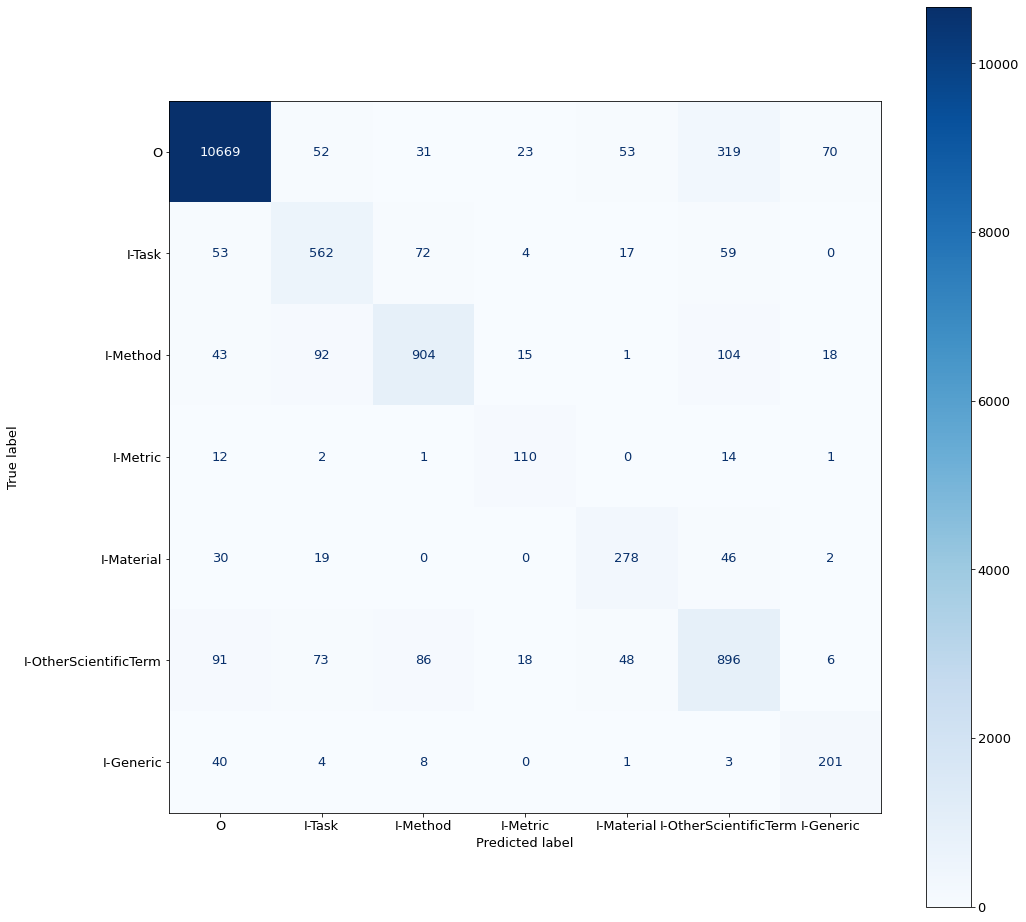

In [ ]:
from sklearn.metrics import mean_squared_error, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 13})

labels = ["O", "I-Task", "I-Method", "I-Metric", "I-Material", "I-OtherScientificTerm", "I-Generic"]
cm = confusion_matrix(output_real[0], output_preds[0], labels=labels)
for x in range(len(output_real)-1):
  cm += confusion_matrix(output_real[x+1], output_preds[x+1], labels=labels)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
del cm

In [ ]:
len(output_real)

551

# Test over Text

In [ ]:
def prepare_input(txt):
  inputs = BertTokenizer(txt, return_tensors='pt', padding='max_length', truncation=True, max_length=150).to('cuda')
  return inputs

input_text = ["English is shown to be trans-context-free on the basis of coordinations of the respectively type that involve strictly syntactic cross-serial agreement."]
#input_text = ["The transient analysis of gyro-elastic structured media, composed of periodically placed masses interconnected by elastic rods and attached to gyroscopic spinners, is presented."] 
#input_text = ["The results indicated that thermal curing promoted the early strength of mortars, while decreased the late strength of mortars."] 
#input_text = ["A wide variety of processes are attested in the literature, and we find different forms of clippings in our data, including mixtures of different clippings, homophone respellings, phonetic respellings in-cluding informal oral forms, initialisms (but no acronyms), and mixtures of clipping together with homo-phone and phonetic respellings."] 

input_text = ["The goal is to accurately predict the running time of applications for task scheduling and job migration."] 
input_text = ["This paper reports on the development of a cross-domain framework for describing complex design practices."] 
input_text = ["Studies of inequality in China typically ignore cost of liv-ing differences between areas."] 
input_text = ["The present study was designed to explore the long-term differences be-tween three mouse models for depression."]
input_text = ["Finally, regarding professional competencies, teachers appeared to be largely unprepared to conduct language assessments consistent with the LAR demands."] 

#input_text = ["propose a fast and reliable restoration method of virtual resources on OpenStack when physical servers or virtual machines are down."] 
#input_text = ["The results from our simulations reveal that the network assisted adaptation clearly outperforms the purely client-based DASH heuristics in some of the metrics, not all of them, particularly, in situations when the achievable throughput is moderately high or the link quality of the mobile clients does not differ from each other substantially."] 
#input_text = ["For hard rock drilling in coal mine, the drilling efficiency and service life of polycrystalline diamond compact bit are very low."] 
#input_text = ["Capturing changes in foreign reserves and exchange rates through the exchange market pressure, this article investigates whether economic policy uncertainty plays any role in exchange market pressure movements while controlling for the effects of domestic and external factors."] 
#input_text = ["This paper presents design of an self contained actuators unit in wide area damping control of power system in stabilizing system response for both nominal system condition and during actuator faults."] 

#input_text = ["Ultrasound-based brain stimulation techniques may become a powerful new technique to modulate the human brain in a focal and targeted manner."] 
input_text = ["Recent work pre-training Transformers with self-supervised objectives on large text corpora has shown great success when fine-tuned on downstream NLP tasks including text summarization."]

# Tokenize + pad
inputs = prepare_input(input_text)

#inputs
#print(inputs)

In [ ]:
# Pytorch thing (if we aren't training, do this)
ner_model.eval()

# Get predictions
preds = ner_model(**inputs).cpu().detach().numpy()
preds = np.argmax(preds, axis=-1)[0]
pred_labels = [ID2Entity(x) for x in preds]

# Convert token ids to text
tokens = BertTokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Display result
for token, label in zip(tokens, pred_labels):
  if token == '[SEP]':
    break
  if token == '[CLS]':
    continue
  print('{} -> {}'.format(token, label))

recent -> None
work -> None
pre -> None
- -> None
training -> None
transformers -> None
with -> None
self -> None
- -> None
supervised -> None
objectives -> None
on -> None
large -> Material
text -> Material
corpora -> Material
has -> None
shown -> None
great -> None
success -> None
when -> None
fine -> None
- -> None
tuned -> None
on -> None
downstream -> None
nl -> Task
##p -> Task
tasks -> None
including -> None
text -> Task
summar -> Task
##ization -> Task
. -> None


# Model Save and Load

In [ ]:
print("Our model: \n\n", ner_model, '\n')
print("The state dict keys: \n\n", ner_model.state_dict().keys())

Our model: 

 NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
torch.save(ner_model.state_dict(), 'trained_model_dic.pth')

In [ ]:
# download checkpoint file
files.download('trained_model_dic.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls

checkpoint.pth	  model-fold-1.pth  model-fold-4.pth  trained_model_dic.pth
dev.json	  model-fold-2.pth  sample_data       trained_scibert_ner_model
model-fold-0.pth  model-fold-3.pth  test.json	      train.json


Loading the model

In [ ]:
!ls

dev.json  sample_data  test.json  trained_model_dic.pth  train.json


In [ ]:
state_dict = torch.load('trained_model_dic.pth')
print(state_dict.keys())

odict_keys(['sci_embeddings.embeddings.position_ids', 'sci_embeddings.embeddings.word_embeddings.weight', 'sci_embeddings.embeddings.position_embeddings.weight', 'sci_embeddings.embeddings.token_type_embeddings.weight', 'sci_embeddings.embeddings.LayerNorm.weight', 'sci_embeddings.embeddings.LayerNorm.bias', 'sci_embeddings.encoder.layer.0.attention.self.query.weight', 'sci_embeddings.encoder.layer.0.attention.self.query.bias', 'sci_embeddings.encoder.layer.0.attention.self.key.weight', 'sci_embeddings.encoder.layer.0.attention.self.key.bias', 'sci_embeddings.encoder.layer.0.attention.self.value.weight', 'sci_embeddings.encoder.layer.0.attention.self.value.bias', 'sci_embeddings.encoder.layer.0.attention.output.dense.weight', 'sci_embeddings.encoder.layer.0.attention.output.dense.bias', 'sci_embeddings.encoder.layer.0.attention.output.LayerNorm.weight', 'sci_embeddings.encoder.layer.0.attention.output.LayerNorm.bias', 'sci_embeddings.encoder.layer.0.intermediate.dense.weight', 'sci_emb

In [ ]:
ner_model = NerModel(BertEmbModel).to('cuda')
ner_model.load_state_dict(state_dict)

<All keys matched successfully>

# Obtain datasets' weights values (Do not run - fixed values)

In [ ]:
zero = 0
one=0
two=0 
three=0
four=0
five=0
six=0
local_set = train
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1
    
print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)

0:  36134 1:  2658 2:  3905 3:  485 4:  1356 5:  3567 6:  1029


In [ ]:
zero = 0
one=0
two=0 
three=0
four=0
five=0
six=0
local_set = test
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1
    
print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)

In [ ]:
zero = 0
one=0
two=0 
three=0
four=0
five=0
six=0
local_set = val
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1
    
print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)